## 1. Data import

### Library Set-up

In [3]:
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
from itertools import product

from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, \
CountVectorizer, HashingTF, IDF, StringIndexer,\
CountVectorizerModel
from pyspark.ml.pipeline import Pipeline, Transformer
from pyspark.ml.classification import LogisticRegression, NaiveBayes,\
LinearSVC, DecisionTreeClassifier, GBTClassifier,\
NaiveBayesModel, LinearSVCModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import nltk
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Package wordnet is already up-to-date!

### Fetch data from S3

In [6]:
ACCESS_KEY = ""
SECRET_KEY = ""
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
BUCKET_NAME = "spam"
MOUNT_NAME = "spam"

try:
  dbutils.fs.unmount("/mnt/%s/" % MOUNT_NAME)
except:
  print("Could not unmount %s for first time import." % MOUNT_NAME)

dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

path,name,size
dbfs:/mnt/spam/spam.csv,spam.csv,503663


## 2. Preprocessing & EDA

In [8]:
spam = spark.read.format('csv')\
            .options(header='true', inferSchema='true')\
            .load('/mnt/spam/spam.csv')
spam.show(10)

+----+--------------------+----+----+----+
 v1| v2| _c2| _c3| _c4|
+----+--------------------+----+----+----+
 ham|Go until jurong p...|null|null|null|
 ham|Ok lar... Joking ...|null|null|null|
spam|Free entry in 2 a...|null|null|null|
 ham|U dun say so earl...|null|null|null|
 ham|Nah I don't think...|null|null|null|
spam|FreeMsg Hey there...|null|null|null|
 ham|Even my brother i...|null|null|null|
 ham|As per your reque...|null|null|null|
spam|WINNER!! As a val...|null|null|null|
spam|Had your mobile 1...|null|null|null|
+----+--------------------+----+----+----+
only showing top 10 rows

In [9]:
spam.printSchema()

root
-- v1: string (nullable = true)
-- v2: string (nullable = true)
-- _c2: string (nullable = true)
-- _c3: string (nullable = true)
-- _c4: string (nullable = true)

Drop the last three columns which are not relevant for the task

In [11]:
columns_to_drop = ['_c2', '_c3', '_c4']
spam = spam.drop(*columns_to_drop)

Rename the first two columns

In [13]:
spam = spam.withColumnRenamed('v1','label')
spam = spam.withColumnRenamed('v2','text')
spam.show(10)

+-----+--------------------+
label| text|
+-----+--------------------+
 ham|Go until jurong p...|
 ham|Ok lar... Joking ...|
 spam|Free entry in 2 a...|
 ham|U dun say so earl...|
 ham|Nah I don't think...|
 spam|FreeMsg Hey there...|
 ham|Even my brother i...|
 ham|As per your reque...|
 spam|WINNER!! As a val...|
 spam|Had your mobile 1...|
+-----+--------------------+
only showing top 10 rows

In [14]:
spam.count()

Out[8]: 5574

### Missing values

In [16]:
spam.where('label is NULL or text is NULL').show()

+------+----+
 label|text|
+------+----+
ham"""|null|
+------+----+

In [17]:
# Drop missing values
spam = spam.dropna()
spam.count()

Out[10]: 5573

Reformat labels

In [19]:
spam.select('label').distinct().show()

+------+
 label|
+------+
ham"""|
 ham|
 spam|
+------+

In [20]:
spam = spam.withColumn('label', regexp_replace('label', '"""', ''))

In [21]:
spam.select('label').distinct().show()

+-----+
label|
+-----+
 ham|
 spam|
+-----+

### Target: class balance

In [23]:
spam.groupby('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 ham| 4826|
 spam| 747|
+-----+-----+

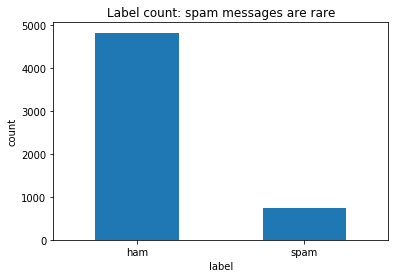

In [24]:
label_count = spam.groupby('label').count().toPandas()
label_count.plot(x='label', y='count', kind='bar', legend=None)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.title('Label count: spam messages are rare')

### Wordcloud

In [26]:
def plot_wordcloud(df, label):
  condition = 'label=\"' + label + '\"'
  print(condition)
  text = df.filter(condition)\
           .select('text')\
           .rdd.flatMap(lambda x: x)\
           .collect() # list of strings
  text = ''.join(str(t) for t in text) # string
  
  wordcloud = WordCloud(max_font_size=50, 
                        max_words=100, 
                        background_color='white').generate(text)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(label, fontsize=15)
  plt.show()

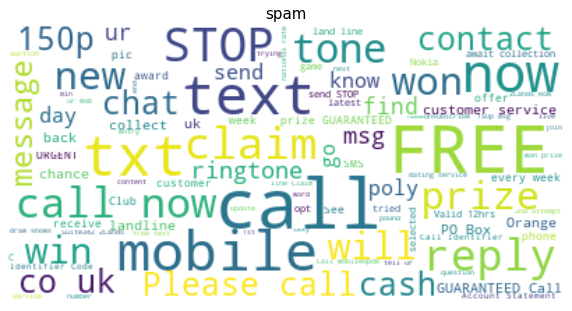

In [27]:
plot_wordcloud(spam, 'spam')

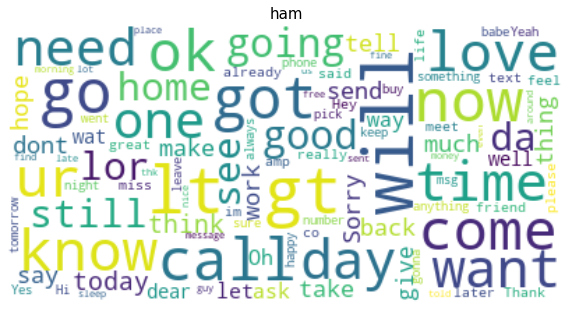

In [28]:
plot_wordcloud(spam, 'ham')

- Non-spam messages: sentiment words (e.g., love, good, ok, sorry)
- Spam messages: ad-related words (e.g., free, call, mobile, claim, txt, text)

### Special characters

In [31]:
def match_text(pattern, col_name):
  """
  Matches text with an RegEx. 
  Summarizes results in a new column: col_name_perc
  """
  col_name += '_perc'
  spam.groupby('label')\
    .agg((100*count(when(spam.text.rlike(pattern), True))/count('*')).alias(col_name))\
    .select('label', bround(col_name, 2).alias(col_name))\
    .show()

#### Exclamation marks

In [33]:
match_text('[!]', 'exclam')

+-----+-----------+
label|exclam_perc|
+-----+-----------+
 ham| 11.58|
 spam| 48.86|
+-----+-----------+

#### Question marks

In [35]:
match_text('[?]', 'qmark')

+-----+----------+
label|qmark_perc|
+-----+----------+
 ham| 22.46|
 spam| 17.8|
+-----+----------+

#### Punctuations in general

In [37]:
match_text('[^\\w\\s]', 'punc')

+-----+---------+
label|punc_perc|
+-----+---------+
 ham| 90.88|
 spam| 97.46|
+-----+---------+

Spam messages are more likely to use exclamation marks.

There's not much difference in use of question marks and punctuations in general.

#### Digits

In [40]:
match_text('[0-9]', 'digit')

+-----+----------+
label|digit_perc|
+-----+----------+
 ham| 15.5|
 spam| 94.78|
+-----+----------+

Spam messages are more likely to use numbers.

### URL

In [43]:
match_text("""((http|ftp)://(.*)\\.([a-z]+)) | (www.*\\.([a-z]+))""", 
           'url')

+-----+--------+
label|url_perc|
+-----+--------+
 ham| 0.04|
 spam| 11.65|
+-----+--------+

Spam messages are more likely to use URLs.

### Message length

In [46]:
spam = spam.withColumn('length', length('text'))

In [47]:
spam.show(5)

+-----+--------------------+------+
label| text|length|
+-----+--------------------+------+
 ham|Go until jurong p...| 111|
 ham|Ok lar... Joking ...| 29|
 spam|Free entry in 2 a...| 155|
 ham|U dun say so earl...| 49|
 ham|Nah I don't think...| 61|
+-----+--------------------+------+
only showing top 5 rows

In [48]:
spam.groupby('label')\
  .agg(min('length'), max('length'), avg('length'))\
  .show()

+-----+-----------+-----------+------------------+
label|min(length)|max(length)| avg(length)|
+-----+-----------+-----------+------------------+
 ham| 2| 910| 71.07065893079155|
 spam| 13| 223|138.45917001338688|
+-----+-----------+-----------+------------------+

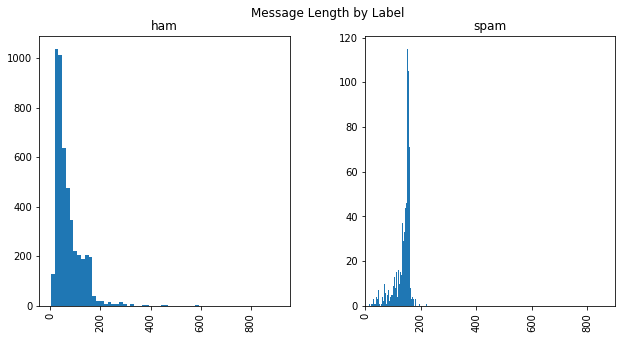

In [49]:
length = spam.select('label', 'length').toPandas()
length.hist(column='length', by='label', bins=60, figsize=(10, 5))
plt.suptitle('Message Length by Label')
plt.xlim(0, 900)

Spam messages seem to be longer.

### Train-test-split

In [52]:
SEED = 42
train, test = spam.randomSplit([0.8, 0.2], seed=SEED)

In [53]:
train.count(), test.count()

Out[30]: (4502, 1071)

In [54]:
train.groupby('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 ham| 3903|
 spam| 599|
+-----+-----+

In [55]:
test.groupby('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 ham| 923|
 spam| 148|
+-----+-----+

### Text preprocessing
- Text
  - Removal of special characters (punctuations and digits)
  - Tokenization
  - Removal of stopwords
  - Stemmatization
  - Vectorization (CountVectorizer, HashingTF)
  - TF-IDF weighting
- Label
  - Map to numerical indices
  
The preprocessing steps will be integrated in the model pipeline and tuned.

## 3. Model

### Custom Transformer
#### 1. TextFilter

In [59]:
class TextFilter(Transformer):
    """
    A custom Transformer that removes special characters and digits in the text
    """

    def __init__(self, inputCol, outputCol):
        super(TextFilter, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df: DataFrame) -> DataFrame:
      # Remove punctuations -> digits -> extra spaces between words 
      # (so that tokenization will not include whitespace character)
      df = df.withColumn(self.outputCol, regexp_replace(self.inputCol, '[^\\w\\s]', ' '))\
              .withColumn(self.outputCol, regexp_replace(self.outputCol, '[\\d+]', ' '))\
              .withColumn(self.outputCol, regexp_replace(self.outputCol, '\\s+', ' '))
      
      return df

#### 2.1 Stemmer

In [61]:
class Stemmer(Transformer):
    """
    A custom Transformer that performs stemmatization using SnowballStemmer from NLTK
    """

    def __init__(self, inputCol, outputCol):
        super(Stemmer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.stemmer = SnowballStemmer(language='english')
        self.stemmer_udf = udf(lambda tokens: [self.stemmer.stem(t) for t in tokens], ArrayType(StringType()))

    def _transform(self, df: DataFrame) -> DataFrame:
      df = df.withColumn(self.outputCol, self.stemmer_udf(self.inputCol))
      return df

#### 2.2 Lemmatizer

In [63]:
class Lemmatizer(Transformer):
    """
    A custom Transformer that performs lemmatization using WordNetLemmatizer from NLTK
    """

    def __init__(self, inputCol, outputCol):
        super(Lemmatizer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.lemmatizer = WordNetLemmatizer()
        self.lemmatizer_udf = udf(lambda tokens: [self.lemmatizer.lemmatize(t) for t in tokens], ArrayType(StringType()))

    def _transform(self, df: DataFrame) -> DataFrame:
      df = df.withColumn(self.outputCol, self.lemmatizer_udf(self.inputCol))
      return df

#### Testing

In [65]:
def test_transformer(df):
  """
  Checks if the transformers work as expected.
  """
  tfilter = TextFilter(inputCol='text', outputCol='text_cleaned')
  test_df = tfilter.transform(df)
  tokenizer = Tokenizer(inputCol='text_cleaned', outputCol='words')
  test_df = tokenizer.transform(test_df)
  stemmer = Stemmer(inputCol='words', outputCol='words_stemmed')
  test_df = stemmer.transform(test_df)
  lemmatizer = Lemmatizer(inputCol='words', outputCol='words_lammatized')
  test_df = lemmatizer.transform(test_df)
  
  return test_df

In [66]:
test_df = test_transformer(spam)

In [67]:
test_df.filter('label = "spam"')\
  .select('text', 'text_cleaned', 'words_stemmed', 'words_lammatized')\
  .show(1, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
text |text_cleaned |words_stemmed |words_lammatized |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's|Free entry in a wkly comp to win FA Cup final tkts st May Text FA to to receive entry question std txt rate T C s apply over s|[free, entri, in, a, wkli, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receiv, entri, question, std, txt, rate, t, c, s, appli, over, s]|[free, entry, in, a, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive, entry, question, std, txt, rate, t, c, s, apply, over, s]|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row

Transformers work as expected. We will integrate the transformers into the model pipeline.

*Note: Stemmer vs. Lemmatizer*
- Both increase recall, with lemmatization giving up some of that recall to increase precision.
- Stemmer is faster
- Lemmatizer returns actual words

For our task, **precision** is a priority, as users don’t want to miss important messages and therefore decreasing FP is priority. 

Therefore, we will use lemmatizer to get the word roots.

### Pipeline

In [70]:
def fit_model(model_name, train=train, test=test, 
              preprocess_all=True, use_tfidf=False, 
              metric='accuracy',
              tuning=False, num_folds=5, 
              results=None, return_fitted=False):
  """
  Trains and tunes a model pipeline.
  @preprocess_all: whether all preprocessing steps are carried out (Bool). 
                   For baseline: no TextFilter, StopWordsRemover, Lemmatizer
  @use_tfidf: whether TF-IDF is used for vectorization (Bool)
  @metric: metric used for evaluation (Str), e.g., accuracy, f1
  @tuning: whether the model will be tuned (Bool)
  @num_folds: CV fold (Int)
  @results: test results (pd.DataFrame)
  @return_fitted: whether the fitted model (and predictions) will be returned (Bool)
  """
  
  # Instantiate models
  label_col, features_col = 'label_index', 'features'
  model_dict = {
    'lr': LogisticRegression(labelCol=label_col, featuresCol=features_col),
    'nb': NaiveBayes(labelCol=label_col, featuresCol=features_col),
    'svm': LinearSVC(labelCol=label_col, featuresCol=features_col),
    'dt': DecisionTreeClassifier(labelCol=label_col, featuresCol=features_col, seed=SEED),
    'gbt': GBTClassifier(labelCol=label_col, featuresCol=features_col, seed=SEED)
  }
  model = model_dict[model_name]
  model_name = model.__class__.__name__ # Substitute for full name for display
  
  # Text preprocessing
  label_indexer = StringIndexer(inputCol='label',outputCol='label_index')
  
  if not preprocess_all:
    tokenizer = Tokenizer(inputCol='text', outputCol='words_cleaned')
  else:
    tfilter = TextFilter(inputCol='text', outputCol='text_cleaned')
    tokenizer = Tokenizer(inputCol='text_cleaned', outputCol='words')
    remover = StopWordsRemover(inputCol='words', outputCol='words_filtered')
    lemmatizer = Lemmatizer(inputCol='words_filtered', outputCol='words_cleaned')
  
  if use_tfidf:
    hashingTF = HashingTF(inputCol='words_cleaned', outputCol='tf', 
                          numFeatures=1000)
    idf = IDF(inputCol='tf', outputCol='features')
    if not preprocess_all: # Baseline
      stages = [tokenizer, hashingTF, idf, 
                label_indexer, model]
    else:
      stages = [tfilter, tokenizer, remover, lemmatizer, hashingTF, idf, 
                label_indexer, model]
  else: # Countvectorizer
    cv = CountVectorizer(inputCol='words_cleaned', outputCol='features', 
                         vocabSize=1000)
    if not preprocess_all:
      stages = [tokenizer, cv,
                label_indexer, model]
    else:
      stages = [tfilter, tokenizer, remover, lemmatizer, cv, 
                label_indexer, model]
  
  pipeline = Pipeline(stages=stages)
  
  evaluator = MulticlassClassificationEvaluator(labelCol='label_index', 
                                                predictionCol='prediction',
                                                metricName=metric)
  """
  Remark on evaluator: though we have a binary classification problem,
  we use MulticlassClassificationEvaluator for it offers a broader range 
  of options for metrics.
  """
  
  # Tuning hyperparameters (for NB/SVM)
  if not tuning:
    pipeline = pipeline.fit(train)
    predictions = pipeline.transform(test)
  else:
    # Create parameter grid
    if use_tfidf:
      param_grid = ParamGridBuilder()\
        .addGrid(hashingTF.numFeatures, [1000, 5000])\
        .addGrid(idf.minDocFreq, [2, 4])
    else:
      param_grid = ParamGridBuilder()\
        .addGrid(cv.vocabSize, [1000, 5000])\
        .addGrid(cv.minDF, [2, 4])
    if model_name == 'svm':
      param_grid = param_grid\
        .addGrid(model.regParam, [0.0, 0.5, 1.0])\
        .addGrid(model.maxIter, [100, 200])
    if model_name == 'nb':
      param_grid = param_grid\
        .addGrid(model.smoothing, [0.5, 1.0, 1.5])
    
    param_grid = param_grid.build()
    
    pipeline = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=num_folds,
                              parallelism=2) 
    pipeline = pipeline.fit(train)
    predictions = pipeline.bestModel.transform(test)
  
  # Evaluation
  score = evaluator.evaluate(predictions)
  print(f'Test set {metric} for {model_name}: {100*score:.2f}')
  
  res = pd.DataFrame([[model_name, preprocess_all, tuning, score]], 
                     columns=['classifier', 'preprocess_all', 'tuning', 'test_score'])
  
  if results is None:
    results = pd.DataFrame(columns=['classifier', 'preprocess_all', 'tuning', 'test_score'])
  
  final_results = pd.concat([results, res])
  
  if return_fitted:
    return pipeline, predictions, final_results
  else:
    return final_results

### Baseline: Logistic Regression (with minimum preprocessing)

In [72]:
model_results = fit_model('lr', preprocess_all=False)

Test set accuracy for LogisticRegression: 95.24

### Naive Bayes

In [74]:
model_results = fit_model('nb', results=model_results)

Test set accuracy for NaiveBayes: 98.13

In [75]:
_ = fit_model('nb', use_tfidf=True)

Test set accuracy for NaiveBayes: 93.37

*Remark on vectorizer:*
- HashingTF is more efficient, but irreversible. 
- Hashed input can be harder to interpret and monitor.
- We will use CountVectorizer as it stores vocabulary, which can be useful when determining words that are likely to be in spams.

### SVM

In [78]:
model_results = fit_model('svm', results=model_results)

Test set accuracy for LinearSVC: 98.60

### Decision Tree

In [80]:
model_results = fit_model('dt', results=model_results)

Test set accuracy for DecisionTreeClassifier: 93.84

### Gradient-boosted Tree

In [82]:
model_results = fit_model('gbt', results=model_results)

Test set accuracy for GBTClassifier: 96.17

In [83]:
model_results.sort_values(by='test_score', ascending=False)

,classifier,preprocess_all,tuning,test_score
0,LinearSVC,True,False,0.985994
0,NaiveBayes,True,False,0.981326
0,GBTClassifier,True,False,0.961718
0,LogisticRegression,False,False,0.952381
0,DecisionTreeClassifier,True,False,0.938375


SVM and Naive Bayes have better performances and are more efficient in terms of runtime. 

Indeed, these are among the most popular classifiers for spam detection.

Tree-based models have poorer performances than the baseline, which might be attributed to overfitting.

### Tuning

In [86]:
def get_best_params(cv_results):
  """
  Prints the best parameter setting from a cross-validated model.
  """
  print('Best parameter setting:')
  stages = cv_results.bestModel.stages
  for s in stages:
    if isinstance(s, CountVectorizerModel):
      print(f'CountVectorizer: vocabSize={s.getVocabSize()}')
      print(f'CountVectorizer: minDF={s.getMinDF()}')
    if isinstance(s, NaiveBayesModel):
      print(f'NaiveBayesModel: Smoothing={s.getSmoothing()}')
    if isinstance(s, LinearSVCModel):
      print(f'LinearSVCModel: RegParam={s.getRegParam()}')
      print(f'LinearSVCModel: MaxIter={s.getMaxIter()}')

#### SVM

In [88]:
svm_cv, svm_pred, model_results = fit_model('svm', tuning=True, 
                                            results=model_results, 
                                            return_fitted=True)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Test set accuracy for LinearSVC: 98.69

In [89]:
get_best_params(svm_cv)

Best parameter setting:
CountVectorizer: vocabSize=1000
CountVectorizer: minDF=2.0
LinearSVCModel: RegParam=0.0
LinearSVCModel: MaxIter=100

#### Naive Bayes

In [91]:
nb_cv, nb_pred, model_results = fit_model('nb', tuning=True,
                                          results=model_results, 
                                          return_fitted=True)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Test set accuracy for NaiveBayes: 98.60

In [92]:
get_best_params(nb_cv)

Best parameter setting:
CountVectorizer: vocabSize=5000
CountVectorizer: minDF=2.0
NaiveBayesModel: Smoothing=1.0

In [93]:
model_results.sort_values(by='test_score', ascending=False)

,classifier,preprocess_all,tuning,test_score
0,LinearSVC,True,True,0.986928
0,LinearSVC,True,False,0.985994
0,NaiveBayes,True,True,0.985994
0,NaiveBayes,True,False,0.981326
0,GBTClassifier,True,False,0.961718
0,LogisticRegression,False,False,0.952381
0,DecisionTreeClassifier,True,False,0.938375


Our model performances improved after tuning.

### Evaluation

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Reference: https://runawayhorse001.github.io/LearningApacheSpark/classification.html
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
#     if normalize:
#       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#       print("Normalized confusion matrix")
#     else:
#       print('Confusion matrix, without normalization')
#     print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#     fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()

In [97]:
def evaluate_model(predictions, metric):
  """
  Evaluates a model by confusion matrix and summary statistics.
  """
  pred_actual = predictions.select('prediction', 'label_index').rdd
  metrics = MulticlassMetrics(pred_actual)
  
  if metric == 'cm':
    cm = metrics.confusionMatrix().toArray()
    plot_confusion_matrix(cm, ['ham', 'spam'])
  if metric == 'summary':
    print('Summary Stats:')
    print(f'Precision = {metrics.precision(1.0):.2f}')
    print(f'Recall = {metrics.recall(1.0):.2f}')
    print(f'F1 = {metrics.fMeasure(1.0):.2f}')

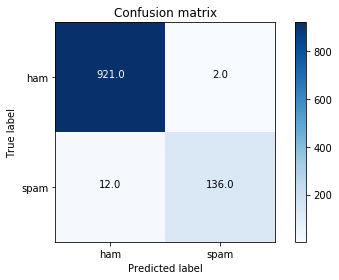

In [98]:
evaluate_model(svm_pred, 'cm')

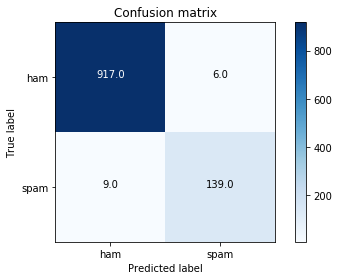

In [99]:
evaluate_model(nb_pred, 'cm')

In [100]:
evaluate_model(svm_pred, 'summary')

Summary Stats:
Precision = 0.99
Recall = 0.92
F1 = 0.95

In [101]:
evaluate_model(nb_pred, 'summary')

Summary Stats:
Precision = 0.96
Recall = 0.94
F1 = 0.95

As mentioned before, we would like to minimize FP (and thus maximize precision).

Indeed, the tuned SVM has a lower FP (top-right cell) and a precision as high as 0.99.

In [103]:
svm_pred.select('label_index', 'prediction')\
  .filter('label_index = 1')\
  .show(10)

+-----------+----------+
label_index|prediction|
+-----------+----------+
 1.0| 0.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
+-----------+----------+
only showing top 10 rows

### Feature importance

In [105]:
def get_feature_imp(cv_results, n=30):
  """
  Plots top-n feature importance given a cross-validated model.
  """
  stages = cv_results.bestModel.stages
  cv = [s for s in stages if isinstance(s, CountVectorizerModel)][0]
  model = stages[-1]
  model_name = model.__class__.__name__
  # Get vocabulary from CountVectorizer
  features = cv.vocabulary
  
  # Get coefficients from model
  if isinstance(model, LinearSVCModel):
    coef = model.coefficients
  if isinstance(model, NaiveBayesModel):
    coef = model.theta.toArray()[1] # theta: log of class conditional probabilities
  
  feature_imp = pd.DataFrame({'feature': features, 'coef': coef})
  top_n = feature_imp[['feature', 'coef']].sort_values(by='coef', ascending=False).head(n)
  
  fig, ax = plt.subplots(figsize=(15, 5))
  n_highlight = n // 3
  colors = ['darkorange' if (t in top_n.coef[:n_highlight].tolist())\
            else 'steelblue' for t in top_n.coef]
  sns.barplot(x='feature', y='coef', data=top_n, ax=ax, palette=colors)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_xlabel('Word')
  ax.set_ylabel('Importance')
  ax.set_title(f'Top {n} Words to Be Predicted as Spam by {model_name}', fontsize=14)

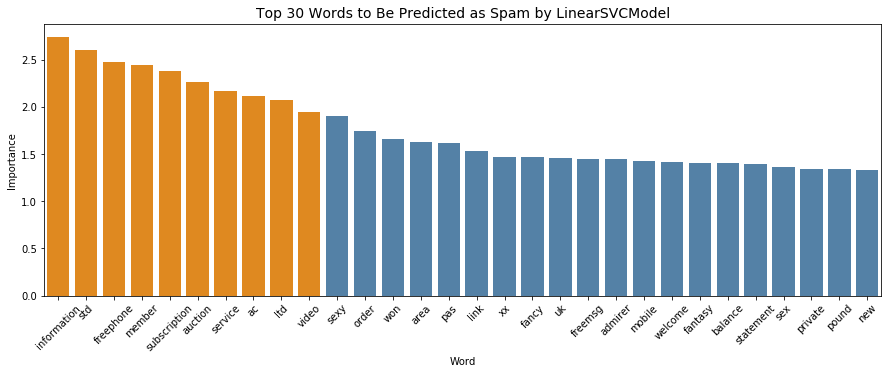

In [106]:
get_feature_imp(svm_cv)

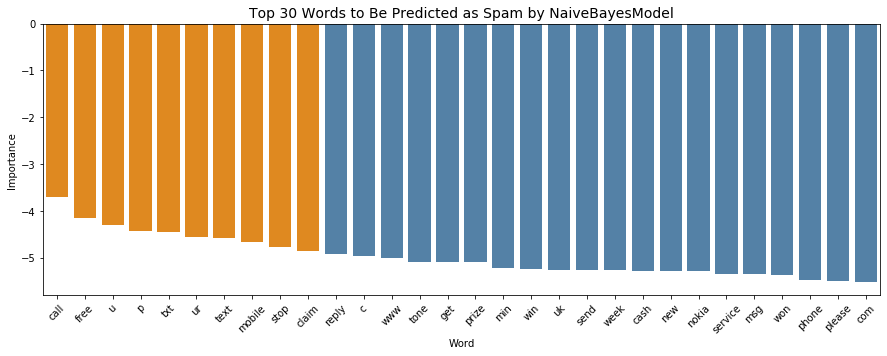

In [107]:
get_feature_imp(nb_cv)

Based on the coefficients, the top 30 words that will be predicted as spam by our model were plotted. 

Such a finding aligns with the wordcloud we formed before. 

In conclusion, common spam-trigger words are
- Manipulative words, e.g., 'call', 'txt'/'text', 'msg', 'subscription'
- Needy words, e.g., 'free'/'freephone'/'freemsg', 'new', 'prize'
- Cheap words, e.g., 'win'
- Far-fetched words, e.g., 'fancy', 'fantasy'
- Sleezy words, e.g., 'order'

In addition, spams seem to include links, e.g., 'link', 'www', 'com',